In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Subhalo Alignments

Examine the intrinsic alignment between sub-haloes and thier host halo.

## Load Sub-halo Catalog

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0.0, dz_tol=0.01, version_name='halotools_v0p4')
for name in halocat.halo_table.dtype.names:
    print(name)

halo_vmax_firstacc
halo_dmvir_dt_tdyn
halo_macc
halo_scale_factor
halo_vmax_mpeak
halo_m_pe_behroozi
halo_xoff
halo_spin
halo_scale_factor_firstacc
halo_c_to_a
halo_mvir_firstacc
halo_scale_factor_last_mm
halo_scale_factor_mpeak
halo_pid
halo_m500c
halo_id
halo_halfmass_scale_factor
halo_upid
halo_t_by_u
halo_rvir
halo_vpeak
halo_dmvir_dt_100myr
halo_mpeak
halo_m_pe_diemer
halo_jx
halo_jy
halo_jz
halo_m2500c
halo_mvir
halo_voff
halo_axisA_z
halo_axisA_x
halo_axisA_y
halo_y
halo_b_to_a
halo_x
halo_z
halo_m200b
halo_vacc
halo_scale_factor_lastacc
halo_vmax
halo_m200c
halo_vx
halo_vy
halo_vz
halo_dmvir_dt_inst
halo_rs
halo_nfw_conc
halo_hostid
halo_mvir_host_halo


## Define some useful quantities

In [3]:
# get masks for sub-haloes and host-haloes
hosts = (halocat.halo_table['halo_upid']==-1)
subs = (halocat.halo_table['halo_upid']!=-1)

In [4]:
# get the index of each sub-halo's host halo
from halotools.utils import crossmatch, normalized_vectors
inds1, inds2 = crossmatch(halocat.halo_table['halo_hostid'], halocat.halo_table['halo_id'])

In [5]:
# define radial vector between sub-halo and the center of its host halo.
x = np.zeros(len(halocat.halo_table))
y = np.zeros(len(halocat.halo_table))
z = np.zeros(len(halocat.halo_table))
x[inds1] = halocat.halo_table['halo_x'][inds2]
y[inds1] = halocat.halo_table['halo_y'][inds2]
z[inds1] = halocat.halo_table['halo_z'][inds2]

dx = (halocat.halo_table['halo_x'] - x)
dy = (halocat.halo_table['halo_y'] - y)
dz = (halocat.halo_table['halo_z'] - z)

# account for PBCs
mask = (dx>halocat.Lbox[0]/2.0)
dx[mask] = dx[mask] - halocat.Lbox[0]
mask = (dx<-1.0*halocat.Lbox[0]/2.0)
dx[mask] = dx[mask] + halocat.Lbox[0]

mask = (dy>halocat.Lbox[1]/2.0)
dy[mask] = dy[mask] - halocat.Lbox[1]
mask = (dy<-1.0*halocat.Lbox[1]/2.0)
dy[mask] = dy[mask] + halocat.Lbox[1]

mask = (dz>halocat.Lbox[2]/2.0)
dz[mask] = dz[mask] - halocat.Lbox[2]
mask = (dz<-1.0*halocat.Lbox[2]/2.0)
dz[mask] = dz[mask] + halocat.Lbox[2]

# calculate radial distance and radial unit vector
radius = np.sqrt(dx**2+dy**2+dz**2)
r = normalized_vectors(np.vstack((dx, dy, dz)).T)
r = np.nan_to_num(r)

# calculate scaled radial distance (r/r_vir)
scaled_radius = np.zeros(len(halocat.halo_table))
# ignore divide by zero in this case
scaled_radius[inds1] = np.divide(radius[inds1], halocat.halo_table['halo_rvir'][inds2],
                                 out=np.zeros_like(radius[inds1]),
                                 where=halocat.halo_table['halo_rvir'][inds2]!=0)

In [6]:
# define orinetation vecotrs of (sub-)haloes
from rotations import rotation_matrices_from_vectors, elementwise_dot, normalized_vectors
from rotations.rotations3d import project_onto_plane

#define major axis of (sub-)haloes
major_axis = normalized_vectors(np.vstack((halocat.halo_table['halo_axisA_x'],
                                           halocat.halo_table['halo_axisA_y'],
                                           halocat.halo_table['halo_axisA_z'])).T)

#define spin axis of (sub-)haloes
spin_axis = normalized_vectors(np.vstack((halocat.halo_table['halo_jx'],
                                          halocat.halo_table['halo_jy'],
                                          halocat.halo_table['halo_jz'])).T)

# define host orientation vectors for each sub-halo
# major axis
host_major_axis = np.copy(major_axis)
host_major_axis[inds1] = major_axis[inds2]
# spin axis
host_spin_axis = np.copy(spin_axis)
host_spin_axis[inds1] = spin_axis[inds2]

In [7]:
# calculate misalignment angles
from halotools.utils import angles_between_list_of_vectors

# major axis
theta_ma_1 = angles_between_list_of_vectors(r, major_axis)
theta_ma_2 = angles_between_list_of_vectors(host_major_axis, major_axis)

# spin axis
theta_ma_3 = angles_between_list_of_vectors(r, spin_axis)
theta_ma_4 = angles_between_list_of_vectors(host_spin_axis, spin_axis)

# Radial Major Axis Alingment

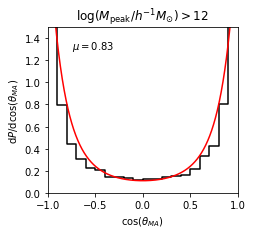

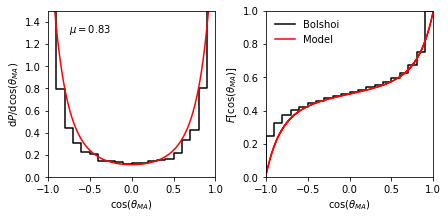

In [8]:
# import misalignment angle distribution model
from intrinsic_alignments.ia_models.ia_model_components import DimrothWatson, inverse_alignment_strength, alignment_strength
from intrinsic_alignments.utils.stat_utils import empirical_cdf, binned_bootstrap_1d

mass_mask = (halocat.halo_table['halo_mpeak']>10**12) & (halocat.halo_table['halo_mvir']>10**11)

d = DimrothWatson()

# define bins
costheta_bins = np.linspace(-1,1,21)
mask = np.isfinite(theta_ma_1) & subs & mass_mask

# calculate differential probability distribution
costheta_1 = np.fabs(np.cos(theta_ma_1[mask]))
uran = np.random.random(len(costheta_1))
costheta_1[uran < 0.5] = -1.0*costheta_1[uran < 0.5] # symmeterize
counts_1 = np.histogram(costheta_1, bins=costheta_bins)[0]
counts_1 = 1.0*counts_1/np.sum(counts_1)/np.diff(costheta_bins)

# fit for shape parameter
k_1 = d.fit(np.cos(theta_ma_1[mask]), floc=0, fscale=1)[0]
full_sample_p_1 = inverse_alignment_strength(k_1)
p = inverse_alignment_strength(k_1)[0]
k_1 = alignment_strength(0.8)

# plot results
x = np.linspace(-1,1,1000)
fig, axes = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.9)

# differential probability distribution
ax = axes
ax.set_title(r'$\log(M_{\rm peak}/{h^{-1}}M_{\odot})>12$')
ax.step(costheta_bins[1:], counts_1, '-', color='black')
ax.plot(x, d.pdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')
ax.text(-0.75, 1.3, r'$\mu=$'+'{:.2f}'.format(p))

plt.show()

filename = "subhalo_misalignment_dist.pdf"
#fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

# plot results
x = np.linspace(-1,1,1000)
fig, axes = plt.subplots(1,2,figsize=(6.3,3.3))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9, wspace=0.3)

# differential probability distribution
ax = axes[0]
ax.step(costheta_bins[1:], counts_1, '-', color='black')
ax.plot(x, d.pdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')
ax.text(-0.75, 1.3, r'$\mu=$'+'{:.2f}'.format(p))

# cumulative distribution
cdf = empirical_cdf(costheta_1, bins=costheta_bins)[0]

ax=axes[1]
p1, = ax.step(costheta_bins, cdf, color='black')
p2, = ax.step(x, d.cdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$F[\cos(\theta_{MA})]$')

ax.legend([p1,p2],['Bolshoi','Model'], loc='upper left', frameon=False, fontsize=10)

plt.show()

#filename = "subhalo_misalignment_dist.pdf"
#fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

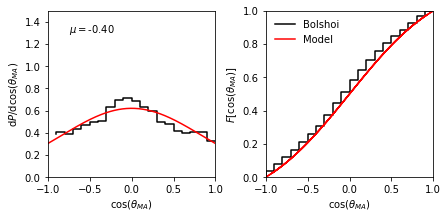

In [9]:
# import misalignment angle distribution model
from watson_dist import DimrothWatson
from intrinsic_alignments.ia_models.ia_model_components import inverse_alignment_strength
from intrinsic_alignments.utils.stat_utils import empirical_cdf, binned_bootstrap_1d

mass_mask = (halocat.halo_table['halo_mpeak']>10**12)

d = DimrothWatson()

# define bins
costheta_bins = np.linspace(-1,1,21)
mask = np.isfinite(theta_ma_3) & subs & mass_mask

# calculate differential probability distribution
costheta_1 = np.fabs(np.cos(theta_ma_3[mask]))
uran = np.random.random(len(costheta_1))
costheta_1[uran < 0.5] = -1.0*costheta_1[uran < 0.5] # symmeterize
counts_1 = np.histogram(costheta_1, bins=costheta_bins)[0]
counts_1 = 1.0*counts_1/np.sum(counts_1)/np.diff(costheta_bins)

# fit for shape parameter
k_1 = d.fit(np.cos(theta_ma_3[mask]), floc=0, fscale=1)[0]
full_sample_p_1 = inverse_alignment_strength(k_1)
p = inverse_alignment_strength(k_1)[0]

# plot results
x = np.linspace(-1,1,1000)
fig, axes = plt.subplots(1,2,figsize=(6.3,3.3))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9, wspace=0.3)

# differential probability distribution
ax = axes[0]
ax.step(costheta_bins[1:], counts_1, '-', color='black')
ax.plot(x, d.pdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')
ax.text(-0.75, 1.3, r'$\mu=$'+'{:.2f}'.format(p))

# cumulative distribution
from intrinsic_alignments.utils.stat_utils import empirical_cdf
cdf = empirical_cdf(costheta_1, bins=costheta_bins)[0]

ax=axes[1]
p1, = ax.step(costheta_bins, cdf, color='black')
p2, = ax.step(x, d.cdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$F[\cos(\theta_{MA})]$')

ax.legend([p1,p2],['Bolshoi','Model'], loc='upper left', frameon=False, fontsize=10)

plt.show()

filename = "subhalo_misalignment_dist.pdf"
#fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

In [10]:
from intrinsic_alignments.utils.stat_utils import binned_bootstrap_1d

Nboot = 2

# check for radial dependence 
rbins = np.logspace(-1.5,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

mass_mask = (halocat.halo_table['halo_mpeak']>10**12)
mask = np.isfinite(theta_ma_1) & subs & mass_mask
costheta_1 = np.fabs(np.cos(theta_ma_1))
costheta_1 = costheta_1[mask]

statisic = lambda x: inverse_alignment_strength(d.fit(x, floc=0, fscale=1)[0])
p, err_p = binned_bootstrap_1d(scaled_radius[mask], costheta_1, rbins,
                               statistic=statisic, Nboot=Nboot)

/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2491: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2492: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[ 0.01345893 -0.05081264]


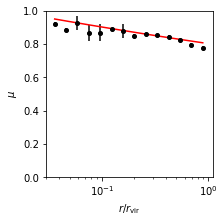

In [11]:
def clipped_powerlaw(x, x0=0.01, alpha=-0.05):
    """
    clipped power law model
    """
    ymax=1.0
    ymin=-1.0
    x = np.atleast_1d(x)
    
    result = np.zeros(len(x))
    result = (x/x0)**alpha
    
    mask = (result>ymax)
    result[mask] = ymax
    mask = (result<ymin)
    result[mask] = ymin
    
    return result

from scipy.optimize import curve_fit

popt, pcov = curve_fit(clipped_powerlaw, rbin_centers, p, sigma=err_p, p0=[0.01, -0.05])
print(popt)

fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot(rbin_centers, clipped_powerlaw(rbin_centers, *popt), '-', color='red')
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlim(0.03,1.1)
ax.set_xlabel(r'$r/r_{\rm vir}$')
ax.set_ylabel(r'$\mu$')
plt.show()

filename = "measured_radial_subhalo_algignment_strength.pdf"
#fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

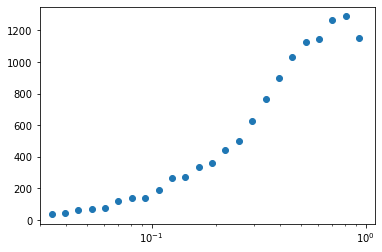

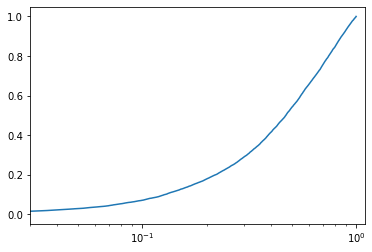

In [12]:
# check for radial dependence 
rbins = np.logspace(-1.5,0.0,25)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0


counts = np.histogram(scaled_radius[mask], bins=rbins)[0]
fig = plt.plot(rbin_centers, counts, 'o')
plt.xscale('log')
plt.xlim(0.03,1.1)
plt.show()

sort_inds = np.argsort(scaled_radius[mask])
f = np.ones(np.sum(mask))/np.sum(mask)
f = np.cumsum(f)
r = scaled_radius[mask][sort_inds]

from scipy.interpolate import interp1d

f_r = interp1d(f,r)

plt.figure()
plt.plot(r, f)
plt.xscale('log')
plt.xlim(0.03,1.1)
plt.show()

rbins = np.logspace(-1.5,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

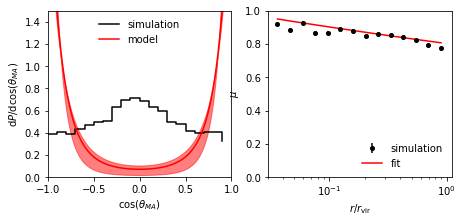

In [13]:
k_0 = alignment_strength(clipped_powerlaw(f_r(0.1), *popt))
k_1 = alignment_strength(clipped_powerlaw(f_r(0.5), *popt))
k_2 = alignment_strength(clipped_powerlaw(f_r(0.9), *popt))

# plot results
x = np.linspace(-1,1,1000)
fig, axes = plt.subplots(1,2,figsize=(6.6,3.3))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9)

# differential probability distribution
ax = axes[0]
#ax.set_title(r'$\log(M_{\rm peak}/{h^{-1}}M_{\odot})>12$')
l1, = ax.step(costheta_bins[:-1], counts_1, '-', color='black', where='post')
ax.fill_between(x, d.pdf(x, k=k_0), d.pdf(x, k=k_2), color='red', alpha=0.5)
l2, = ax.plot(x, d.pdf(x, k=k_1), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')
ax.legend([l1,l2],['simulation','model'], loc='upper center', frameon=False, fontsize=10)

ax=axes[1]
p1 = ax.errorbar(rbin_centers, p, yerr=err_p, fmt='o', ms=4, color='black')
l1, = ax.plot(rbin_centers, clipped_powerlaw(rbin_centers, *popt), '-', color='red')
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlim(0.03,1.1)
ax.set_xlabel(r'$r/r_{\rm vir}$')
ax.set_ylabel(r'$\mu$')
ax.legend([p1,l2],['simulation','fit'], loc='lower right', frameon=False, fontsize=10)

plt.show()


filename = "subhalo_alignment_strength.pdf"
#fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2491: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2492: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


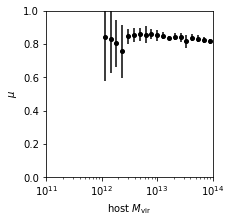

In [14]:
Nboot = 5

# check for host mass dependence
mbins = np.logspace(12,14,20)
mbins_centers = (mbins[:-1]+mbins[1:])/2.0

statisic = lambda x: inverse_alignment_strength(d.fit(x, floc=0, fscale=1)[0])
p, err_p = binned_bootstrap_1d(halocat.halo_table['halo_mvir_host_halo'][mask],
                               costheta_1, mbins, statistic=statisic, Nboot=5)
        
fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(mbins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,10**16], [full_sample_p_1, full_sample_p_1], '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([10**11,10**14])
ax.set_xscale('log')
ax.set_xlabel('host ' + r'$M_{\rm vir}$')
ax.set_ylabel(r'$\mu$')
plt.show()

<ipython-input-15-7366dd145136>:7: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (halocat.halo_table['halo_mvir']/halocat.halo_table['halo_mvir_host_halo'])


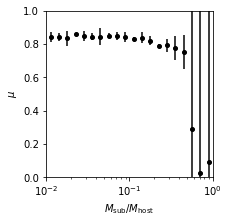

In [15]:
Nboot = 5

# check for mass ratio dependence
ratio_bins = np.logspace(-2,0,21)
ratio_bins_centers = (ratio_bins[:-1]+ratio_bins[1:])/2.0

ratio = (halocat.halo_table['halo_mvir']/halocat.halo_table['halo_mvir_host_halo'])

statisic = lambda x: inverse_alignment_strength(d.fit(x, floc=0, fscale=1)[0])
p, err_p = binned_bootstrap_1d(ratio[mask], costheta_1, ratio_bins, statistic=statisic, Nboot=Nboot)
        
fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(ratio_bins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,2], [full_sample_p_1, full_sample_p_1], '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([0.01,1])
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm sub}/M_{\rm host}$')
ax.set_ylabel(r'$\mu$')
plt.show()

# Host Major Axis Alingment

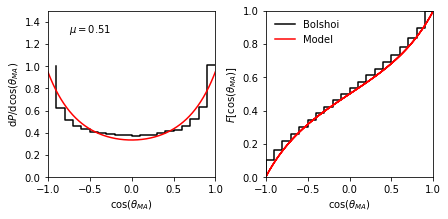

In [16]:
# import misalignment angle distribution model
from intrinsic_alignments.ia_models.ia_model_components import DimrothWatson, inverse_alignment_strength
from intrinsic_alignments.utils.stat_utils import empirical_cdf, binned_bootstrap_1d

d = DimrothWatson()

# define bins
costheta_bins = np.linspace(-1,1,21)
mask = np.isfinite(theta_ma_2) & subs

# calculate differential probability distribution
costheta_2 = np.fabs(np.cos(theta_ma_2[mask]))
uran = np.random.random(len(costheta_2))
costheta_2[uran < 0.5] = -1.0*costheta_2[uran < 0.5] # symmeterize
counts_2 = np.histogram(costheta_2, bins=costheta_bins)[0]
counts_2 = 1.0*counts_2/np.sum(counts_2)/np.diff(costheta_bins)

# fit for shape parameter
k_2 = d.fit(np.cos(theta_ma_2[mask]), floc=0, fscale=1)[0]
full_sample_p_2 = inverse_alignment_strength(k_2)
p = inverse_alignment_strength(k_2)[0]

# plot results
x = np.linspace(-1,1,1000)
fig, axes = plt.subplots(1,2,figsize=(6.3,3.3))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9, wspace=0.3)

# differential probability distribution
ax = axes[0]
ax.step(costheta_bins[1:], counts_2, '-', color='black')
ax.plot(x, d.pdf(x, k=k_2), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')
ax.text(-0.75, 1.3, r'$\mu=$'+'{:.2f}'.format(p))

# cumulative distribution
cdf = empirical_cdf(costheta_2, bins=costheta_bins)[0]

ax=axes[1]
p1, = ax.step(costheta_bins, cdf, color='black')
p2, = ax.step(x, d.cdf(x, k=k_2), '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(\theta_{MA})$')
ax.set_ylabel(r'$F[\cos(\theta_{MA})]$')

ax.legend([p1,p2],['Bolshoi','Model'], loc='upper left', frameon=False, fontsize=10)

plt.show()

/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2491: RuntimeWarning: Mean of empty slice.
  muhat = tmp.mean()
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2492: RuntimeWarning: Degrees of freedom <= 0 for slice
  mu2hat = tmp.var()
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/nvanalfen/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


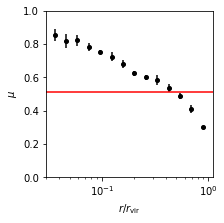

In [17]:
from intrinsic_alignments.utils.stat_utils import binned_bootstrap_1d

Nboot = 5

# check for radial dependence 
rbins = np.logspace(-1.5,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

statisic = lambda x: inverse_alignment_strength(d.fit(x, floc=0, fscale=1)[0])
p, err_p = binned_bootstrap_1d(scaled_radius[mask], costheta_2, rbins,
                               statistic=statisic, Nboot=Nboot)


fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,2], [full_sample_p_2, full_sample_p_2], '-', color='red')
ax.set_ylim([0,1])
ax.set_xscale('log')
ax.set_xlim(0.03,1.1)
ax.set_xlabel(r'$r/r_{\rm vir}$')
ax.set_ylabel(r'$\mu$')
plt.show()

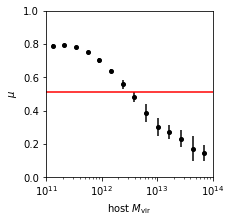

In [18]:
Nboot = 5

# check for host mass dependence
mbins = np.logspace(11,15,20)
mbins_centers = (mbins[:-1]+mbins[1:])/2.0

statisic = lambda x: inverse_alignment_strength(d.fit(x, floc=0, fscale=1)[0])
p, err_p = binned_bootstrap_1d(halocat.halo_table['halo_mvir_host_halo'][mask],
                               costheta_2, mbins, statistic=statisic, Nboot=5)
        
fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(mbins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,10**16], [full_sample_p_2, full_sample_p_2], '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([10**11,10**14])
ax.set_xscale('log')
ax.set_xlabel('host ' + r'$M_{\rm vir}$')
ax.set_ylabel(r'$\mu$')
plt.show()

<ipython-input-19-c75edd511474>:7: RuntimeWarning: divide by zero encountered in true_divide
  ratio = (halocat.halo_table['halo_mvir']/halocat.halo_table['halo_mvir_host_halo'])


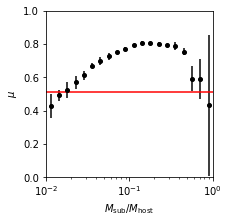

In [19]:
Nboot = 5

# check for mass ratio dependence
ratio_bins = np.logspace(-2,0,21)
ratio_bins_centers = (ratio_bins[:-1]+ratio_bins[1:])/2.0

ratio = (halocat.halo_table['halo_mvir']/halocat.halo_table['halo_mvir_host_halo'])

statisic = lambda x: inverse_alignment_strength(d.fit(x, floc=0, fscale=1)[0])
p, err_p = binned_bootstrap_1d(ratio[mask], costheta_2, ratio_bins, statistic=statisic, Nboot=Nboot)
        
fig, ax = plt.subplots(1,1,figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(ratio_bins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
ax.plot([0.001,2], [full_sample_p_2, full_sample_p_2], '-', color='red')
ax.set_ylim([0,1])
ax.set_xlim([0.01,1])
ax.set_xscale('log')
ax.set_xlabel(r'$M_{\rm sub}/M_{\rm host}$')
ax.set_ylabel(r'$\mu$')
plt.show()

## check for more trends

In [21]:
# check for sub mass dependence
# theta_ma was used previously. I'm assuming it meant theta_ma_3
mbins = np.logspace(10,14,20)
mbins_centers = (mbins[:-1]+mbins[1:])/2.0
inds = np.digitize(halocat.halo_table['halo_mvir'], bins=mbins)
Nboot=20
k = np.zeros((len(mbins)-1,Nboot))
for i in range(0,len(mbins)-1):
    mask = (inds==i) & np.isfinite(theta_ma_3)
    x = np.cos(theta_ma_3[mask])
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

NameError: name 'full_sample_p3' is not defined

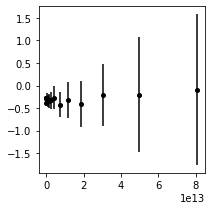

In [24]:
# full_sample_p was used. Not sure which one he means
p = np.mean(inverse_alignment_strength(k), axis=-1)
err_p = np.std(inverse_alignment_strength(k), axis=-1)

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(mbins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
plt.plot([0.001,10**16], [full_sample_p, full_sample_p], '-', color='red')
plt.ylim([0,1])
plt.xlim([10**10,10**14])
plt.xscale('log')
plt.xlabel(r'$M_{\rm vir}$')
plt.ylabel(r'$\mu$')
plt.show()

In [ ]:
# check for sub-halo ellipticity
# theta_ma was used previously. I'm assuming it meant theta_ma_4 and have switched it

q = halocat.halo_table['halo_b_to_a']
s = halocat.halo_table['halo_c_to_a']
e = (1.0-q)/(1.0+q)

ebins = np.logspace(-2,0.0,20)
ebins_centers = (ebins[:-1]+ebins[1:])/2.0
inds = np.digitize(e, bins=ebins)
Nboot=5
k = np.zeros((len(ebins)-1,Nboot))
for i in range(0,len(ebins)-1):
    mask = (inds==i) & np.isfinite(theta_ma_4)
    x = np.cos(theta_ma_4[mask])
    for j in range(0,Nboot):
        xx = np.random.choice(x, size=len(x), replace=True)
        k[i,j] = d.fit(xx, floc=0, fscale=1)[0]

In [ ]:
p = np.mean(inverse_alignment_strength(k), axis=-1)
err_p = np.std(inverse_alignment_strength(k), axis=-1)

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.errorbar(ebins_centers, p, yerr=5*err_p, fmt='o', ms=4, color='black')
plt.plot([0.001,10**16], [full_sample_p, full_sample_p], '-', color='red')
plt.ylim([0,1])
plt.xlim([0.01,1.1])
plt.xscale('log')
plt.xlabel('$e$')
plt.ylabel(r'$\mu$')
plt.show()

## fit for hybrid model alignment

In [ ]:
from halotools.utils import vectors_between_list_of_vectors

def hybrid_alignment_vector(v1, v2, ratio=0.5):
    """
    return the hybrid alignment model alignment vectors
    """
    
    Ngal = np.shape(v1)[0]
    
    a = np.ones(Ngal)*ratio

    v1 = normalized_vectors(v1)
    v2 = normalized_vectors(v2)

    v3_a = normalized_vectors(vectors_between_list_of_vectors(v1, v2, a))
    v3_b = normalized_vectors(vectors_between_list_of_vectors(-1.0*v1, v2, a))
    
    return v3_a, v3_b

N = len(halocat.halo_table)
fs = np.linspace(0,1.0,21)
v1 = np.zeros((len(fs), N, 3))
v2 = np.zeros((len(fs), N, 3))
for i,f in enumerate(fs):
    v1[i,:,:], v2[i,:,:] = hybrid_alignment_vector(r, host_major_axis, fs[i])

In [ ]:
costheta_1 = np.zeros((len(fs), N))
costheta_2 = np.zeros((len(fs), N))
for i in range(0,len(fs)):
    costheta_1[i,:] = np.cos(angles_between_list_of_vectors(v1[i,:,:], major_axis))
    costheta_2[i,:] = np.cos(angles_between_list_of_vectors(v2[i,:,:], major_axis))

In [ ]:
from intrinsic_alignments.ia_models.ia_model_components import inverse_alignment_strength, alignment_strength, watson_mixture_membership, watson_mixture_liklihood

rbins = np.logspace(-1.5,0.0,15)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0
inds = np.digitize(scaled_radius, bins=rbins)

p = np.zeros((len(fs), len(rbins)-1))
log_l = np.zeros((len(fs), len(rbins)-1))
for j in range(0, len(fs)):
    for i in range(0, len(rbins)-1):
        mask = (inds==i+1) & (subs)
        costhetas = np.nan_to_num(np.vstack((costheta_1[j, mask], costheta_2[j, mask])).T)
        p[j,i] = fit_watson_mixture_model(costhetas, verbose=False, max_iter=10)
        k = inverse_alignment_strength(p[j,i])
        f = watson_mixture_membership(costhetas, p[j,i])
        log_l[j,i] = watson_mixture_liklihood(costhetas, f, k)/np.sum(mask)

In [ ]:
plt.imshow(p, vmin=0, vmax=1)
plt.colorbar()
plt.show()

plt.imshow(log_l)
plt.colorbar()
plt.show()

In [ ]:
inds = np.argmax(p,axis=0)
max_ps = np.zeros(len(rbins)-1)
for i in range(0, len(rbins)-1):
    max_ps[i] = p[inds[i],i]

plt.figure()
plt.scatter(rbin_centers, fs[inds], c=max_ps, vmin=0, vmax=1.0)
plt.plot(x, power_law(x, 0.25, -0.3))
plt.colorbar()
plt.xscale('log')
plt.ylim([0.1,1])
plt.show()

x = np.logspace(-2,0,100)
plt.figure()
plt.scatter(rbin_centers, max_ps, c=fs[inds], vmin=0, vmax=1.0)
plt.plot(x, power_law(x, 0.75, -0.05))
plt.colorbar()
plt.xscale('log')
plt.ylim([0.1,1])
plt.show()

In [ ]:
def power_law(x, a, alpha):
    return a*x**alpha

## consider two vvector alignemnts


In [ ]:
from intrinsic_alignments.ia_models.ia_model_components import DimrothWatson, inverse_alignment_strength, alignment_strenth, axes_correlated_with_input_vector
from halotools.utils import angles_between_list_of_vectors

In [ ]:
N = 10000

input_vectors = np.zeros((N,3))
ran = np.random.random(N)
xaxis = np.zeros((N,3))
xaxis[:,0]=1.0
yaxis = np.zeros((N,3))
yaxis[:,1]=1.0
input_vectors[ran<0.5,0] = 1.0
input_vectors[ran>=0.5,1] = 1.0
ps = np.ones(N)*0.6
output_vectors = axes_correlated_with_input_vector(input_vectors, p=ps)
membership = (ran<0.5)

In [ ]:
theta = angles_between_list_of_vectors(output_vectors, xaxis)
x = np.cos(theta)

In [ ]:
costheta_bins = np.linspace(-1,1,21)

counts = np.histogram(x, bins=costheta_bins)[0]
counts = 1.0*counts/np.sum(counts)/np.diff(costheta_bins)

counts1 = np.histogram(x[membership==True], bins=costheta_bins)[0]
counts1 = 1.0*counts1/np.sum(counts1)/np.diff(costheta_bins)

counts2 = np.histogram(x[membership==False], bins=costheta_bins)[0]
counts2 = 1.0*counts2/np.sum(counts2)/np.diff(costheta_bins)

d = DimrothWatson()

xx = np.linspace(-1,1,1000)
fig, ax = plt.subplots(1,1, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, wspace=0.3)
ax.step(costheta_bins[1:], counts, '-', color='black')
ax.step(costheta_bins[1:], counts1, '-', color='grey')
ax.step(costheta_bins[1:], counts2, '-', color='grey')
ax.step(xx, d.pdf(xx, k=alignment_strenth(ps[0])), '-', color='red')
ax.set_ylim([0,1.5])
ax.set_xlim([-1,1])
ax.set_xlabel(r'$\cos(2\theta_{MA})$')
ax.set_ylabel(r'$\mathrm{d}P/\mathrm{d}\cos(\theta_{MA})$')

plt.show()

In [ ]:
from intrinsic_alignments.ia_models.ia_model_components import fit_watson_mixture_model

x1 = np.cos(angles_between_list_of_vectors(output_vectors, xaxis))
x2 = np.cos(angles_between_list_of_vectors(output_vectors, yaxis))

x = np.vstack((x1, x2)).T

p = fit_watson_mixture_model(x, verbose=True)
print(p)